In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
STOPWORDS = set(stopwords.words('english'))
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report

2023-07-05 07:07:06.209685: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-05 07:07:09.452049: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

## Fetch Dataset

In [2]:
path = '../Dataset/'

In [3]:
df1 = pd.read_csv(path+'DelhiDataset_named.csv')
df2 = pd.read_csv(path+'KolkataDataset_named.csv')
df = pd.concat([df1,df2]).sample(frac=1).reset_index()
df.dropna(inplace=True)
df.shape , df1.shape

((23765, 4), (15438, 3))

### Visualize Dataset

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23765 entries, 0 to 23766
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   index       23765 non-null  int64 
 1   Unnamed: 0  23765 non-null  int64 
 2   tweet       23765 non-null  object
 3   label       23765 non-null  object
dtypes: int64(2), object(2)
memory usage: 928.3+ KB


In [5]:
df1.label.value_counts()

Traffic obstruction/car breakdown    4831
Others                               3459
Traffic congestion/heavy traffic     2821
Road closure                         1487
Water logging                        1156
Traffic information/advisory         1001
City program                          416
Accident                              267
Name: label, dtype: int64

In [6]:
df2.label.value_counts()

City program                2150
Roads related congestion    1811
Vehicle breakdown           1636
Closed Avenue               1375
Others                      1103
Road blockage                254
Name: label, dtype: int64

In [7]:
df.label.value_counts()

Traffic obstruction/car breakdown    4831
Others                               4560
Traffic congestion/heavy traffic     2821
City program                         2566
Roads related congestion             1811
Vehicle breakdown                    1636
Road closure                         1487
Closed Avenue                        1375
Water logging                        1156
Traffic information/advisory         1001
Accident                              267
Road blockage                         254
Name: label, dtype: int64

Traffic obstruction/car breakdown = Vehicle breakdown

Traffic congestion/heavy traffic = Roads related congestion

Road closure = Closed Avenue

In [8]:
df.label.replace({'Traffic obstruction/car breakdown':'Vehicle breakdown','Traffic congestion/heavy traffic':'Roads related congestion','Road closure':'Closed Avenue'},inplace=True)

In [9]:
df.label.value_counts()

Vehicle breakdown               6467
Roads related congestion        4632
Others                          4560
Closed Avenue                   2862
City program                    2566
Water logging                   1156
Traffic information/advisory    1001
Accident                         267
Road blockage                    254
Name: label, dtype: int64

[Text(0, 0, 'Water logging'),
 Text(1, 0, 'Closed Avenue'),
 Text(2, 0, 'City program'),
 Text(3, 0, 'Vehicle breakdown'),
 Text(4, 0, 'Roads related congestion'),
 Text(5, 0, 'Others'),
 Text(6, 0, 'Road blockage'),
 Text(7, 0, 'Traffic information/advisory'),
 Text(8, 0, 'Accident')]

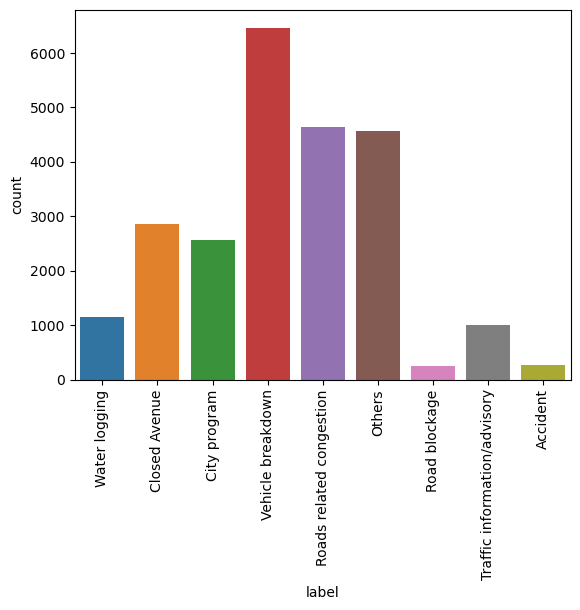

In [10]:
s = sns.countplot(x='label',data=df)
s.set_xticklabels(s.get_xticklabels(),rotation=90)

## Dataset Preprocessing
### Data Cleaning : Stemming and Remove stop words

In [11]:
def print_plot(index):
    example = df[df.index == index][['tweet', 'label']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Product:', example[1])

In [12]:
print_plot(10)
print_plot(100)

Traffic movement is slow at following points due to water logging RA RML Hospital Opp Birla Mandir Minto Bridge 
Product: Water logging
Due to some VVIP Programs traffic will remain heavy at C hexagon India Gate Ashoka Road etc Inconvenience regretted 
Product: Roads related congestion


In [13]:
df = df.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string

        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing.
    text = text.replace('x', '')
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text
df['tweet'] = df['tweet'].apply(clean_text)

In [14]:
df['tweet'] = df['tweet'].str.replace('\d+', '')

/tmp/ipykernel_1416940/205990907.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df['tweet'] = df['tweet'].str.replace('\d+', '')


In [15]:
print_plot(10)
print_plot(100)

traffic movement slow following points due water logging ra rml hospital opp birla mandir minto bridge
Product: Water logging
due vvip programs traffic remain heavy c heagon india gate ashoka road etc inconvenience regretted
Product: Roads related congestion


### Transormation of X data into 'tokenized embedding'

In [16]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 25000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 120
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['tweet'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 10305 unique tokens.


In [17]:
X = tokenizer.texts_to_sequences(df['tweet'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)
X

Shape of data tensor: (23765, 120)


array([[   0,    0,    0, ...,  373,  741,   39],
       [   0,    0,    0, ...,   78,    1,  106],
       [   0,    0,    0, ...,  248,   13,    1],
       ...,
       [   0,    0,    0, ...,    7,  500,  720],
       [   0,    0,    0, ...,  160,    4,   99],
       [   0,    0,    0, ...,  406,    1, 3345]], dtype=int32)

### Transormation of Y data into 'Label Binarized '

In [18]:
Y = df['label'].values
lb = LabelBinarizer()
y = lb.fit_transform(Y)
y

array([[0, 0, 0, ..., 0, 0, 1],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 0]])

### Divide data into Train Test

In [19]:
X_train, X_test, Y_train, Y_test = train_test_split(X,y, test_size = 0.20, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(19012, 120) (19012, 9)
(4753, 120) (4753, 9)


## Defining Model

In [20]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

2023-07-05 07:07:57.296770: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_COMPAT_NOT_SUPPORTED_ON_DEVICE: forward compatibility was attempted on non supported HW
2023-07-05 07:07:57.296818: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: iterhpc
2023-07-05 07:07:57.296827: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: iterhpc
2023-07-05 07:07:57.296942: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 470.199.2
2023-07-05 07:07:57.296973: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 470.182.3
2023-07-05 07:07:57.296982: E tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:312] kernel version 470.182.3 does not match DSO version 470.199.2 -- cannot find working devices in this configuration


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 120, 100)          2500000   
                                                                 
 spatial_dropout1d (SpatialD  (None, 120, 100)         0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 9)                 909       
                                                                 
Total params: 2,581,309
Trainable params: 2,581,309
Non-trainable params: 0
_________________________________________________________________
None


### Training of model on train Data

In [21]:
import keras
epochs = 50
batch_size = 32
STEPS_PER_EPOCH = X_train.size / batch_size
SAVE_PERIOD = 2

st = time.time()
# checkpoint_filepath = '/content/drive/MyDrive/Models/TweetClassification/Merged_1/cp.ckpt'
# model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
#     filepath=checkpoint_filepath,
#     save_weights_only=True,
#     monitor='val_accuracy',
#     mode='max',
#     save_best_only=True)

checkpoint_path = 'MergedCP/cp-{epoch:03d}-{accuracy:0.4f}.hdf5'
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    monitor = 'accuracy',
    mode = max,
    save_best_only = True,
    verbose=1)
#     save_weights_only=True,
#     save_freq= int(SAVE_PERIOD * STEPS_PER_EPOCH))
#     save_freq=epochs,
#     period = 2)

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001),cp_callback])
# history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[model_checkpoint_callback])
et = time.time()
elapsed_time = et - st
print('Execution time: {:0.0f} seconds'.format(elapsed_time))



Epoch 1/50
535/535 [==============================] - ETA: 0s - loss: 0.6982 - accuracy: 0.7607
Epoch 1: accuracy improved from -inf to 0.76072, saving model to MergedCP/cp-001-0.7607.hdf5
535/535 [==============================] - 95s 172ms/step - loss: 0.6982 - accuracy: 0.7607 - val_loss: 0.2167 - val_accuracy: 0.9380
Epoch 2/50
535/535 [==============================] - ETA: 0s - loss: 0.1373 - accuracy: 0.9622
Epoch 2: accuracy improved from 0.76072 to 0.96224, saving model to MergedCP/cp-002-0.9622.hdf5
535/535 [==============================] - 92s 171ms/step - loss: 0.1373 - accuracy: 0.9622 - val_loss: 0.1536 - val_accuracy: 0.9590
Epoch 3/50
535/535 [==============================] - ETA: 0s - loss: 0.0783 - accuracy: 0.9784
Epoch 3: accuracy improved from 0.96224 to 0.97843, saving model to MergedCP/cp-003-0.9784.hdf5
535/535 [==============================] - 92s 173ms/step - loss: 0.0783 - accuracy: 0.9784 - val_loss: 0.1120 - val_accuracy: 0.9732
Epoch 4/50
535/535 [=====

## Save Model and History

In [22]:
import pickle
with open(path+'merged_LSTM_history', 'wb') as file_pi:
    pickle.dump(history, file_pi)

In [23]:
model.save(path+'merged_LSTM_model.h5')

## Load Model and History

In [25]:
# from tensorflow import keras
# model = keras.models.load_model(path+'merged_LSTM_model.h5')

In [26]:
# import pickle
# with open(path+'merged_LSTM_history', "rb") as file_pi:
#   history = pickle.load(file_pi)

## Perform on Test Dataset




In [24]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.2f}\n  Accuracy: {:0.2f}%'.format(accr[0],accr[1]*100))

149/149 [==============================] - 6s 41ms/step - loss: 0.1178 - accuracy: 0.9697
Test set
  Loss: 0.12
  Accuracy: 96.97%


## Result Analysis

### Plot Training Testing Accuracy and Loss

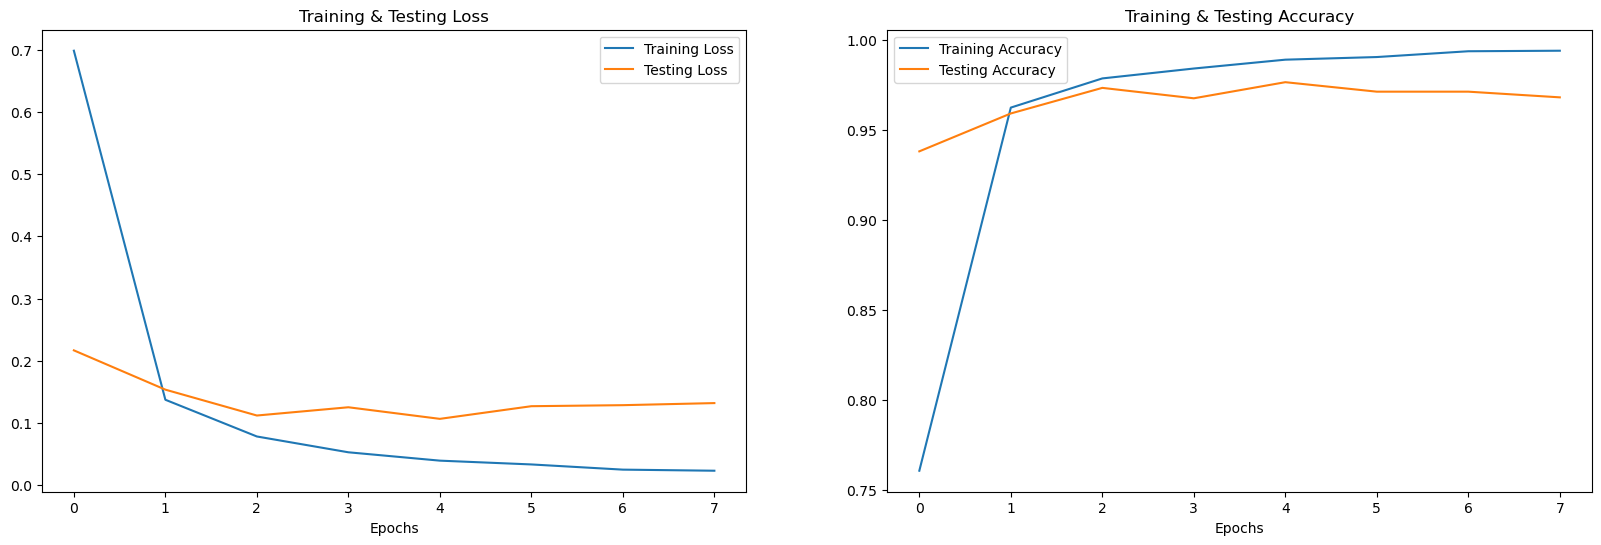

In [25]:
epochList = [i for i in range(len(history.history['loss']))]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochList , train_loss , label = 'Training Loss')
ax[0].plot(epochList , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochList , train_acc , label = 'Training Accuracy')
ax[1].plot(epochList , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

### Prediction of Model on Test Data

In [26]:
pred_test = model.predict(X_test)

149/149 [==============================] - 4s 24ms/step


In [27]:
y_pred = lb.inverse_transform(pred_test)
y_test = lb.inverse_transform(Y_test)

In [28]:
unique, counts = np.unique(y_test, return_counts=True)
print(np.asarray((unique, counts)).T)

[['Accident' '58']
 ['City program' '493']
 ['Closed Avenue' '590']
 ['Others' '875']
 ['Road blockage' '59']
 ['Roads related congestion' '922']
 ['Traffic information/advisory' '211']
 ['Vehicle breakdown' '1311']
 ['Water logging' '234']]


### Plotting Confusion Matrix

<Figure size 3000x1000 with 0 Axes>

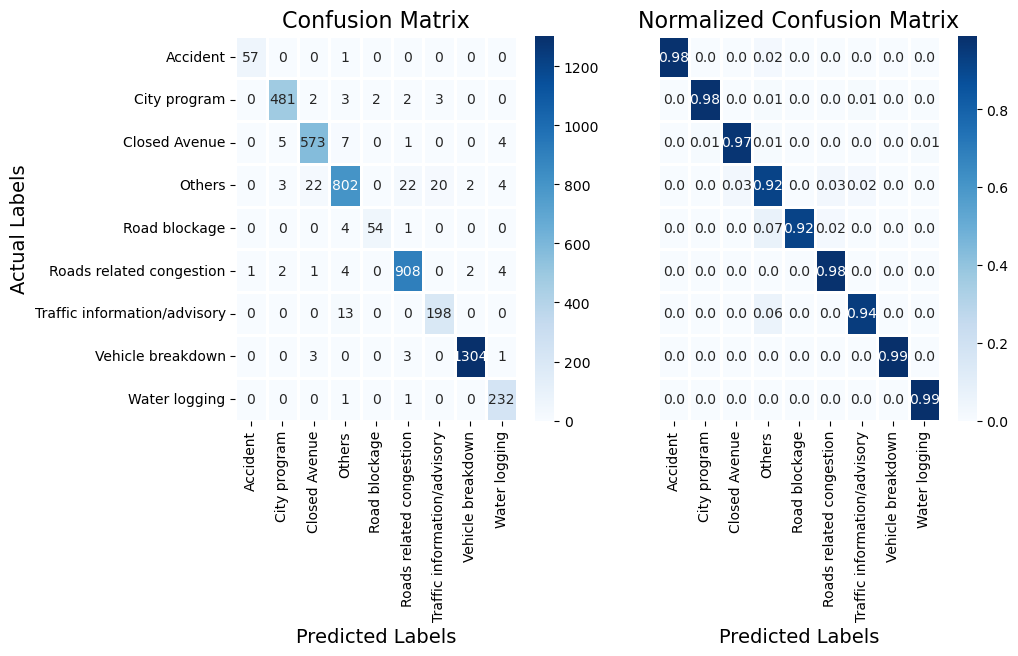

In [54]:
cm = confusion_matrix(y_test, y_pred)
cm1 = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)
plt.figure(figsize = (30, 10))
cm = pd.DataFrame(cm , index = [i for i in lb.classes_] , columns = [i for i in lb.classes_])
cm1 = pd.DataFrame(cm1  , columns = [i for i in lb.classes_])

fig , ax = plt.subplots(1,2,figsize=(10,5))
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=2, annot=True, fmt='',ax=ax[0])
ax[0].set_title('Confusion Matrix', size=16)
ax[0].set_xlabel('Predicted Labels', size=14)
ax[0].set_ylabel('Actual Labels', size=14)

sns.heatmap(cm1, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='',ax=ax[1],yticklabels=False)
ax[1].set_title('Normalized Confusion Matrix', size=16)
ax[1].set_xlabel('Predicted Labels', size=14)
plt.show()

In [32]:
print(classification_report(y_test, y_pred))

                              precision    recall  f1-score   support

                    Accident       0.98      0.98      0.98        58
                City program       0.98      0.98      0.98       493
               Closed Avenue       0.95      0.97      0.96       590
                      Others       0.96      0.92      0.94       875
               Road blockage       0.96      0.92      0.94        59
    Roads related congestion       0.97      0.98      0.98       922
Traffic information/advisory       0.90      0.94      0.92       211
           Vehicle breakdown       1.00      0.99      1.00      1311
               Water logging       0.95      0.99      0.97       234

                    accuracy                           0.97      4753
                   macro avg       0.96      0.96      0.96      4753
                weighted avg       0.97      0.97      0.97      4753



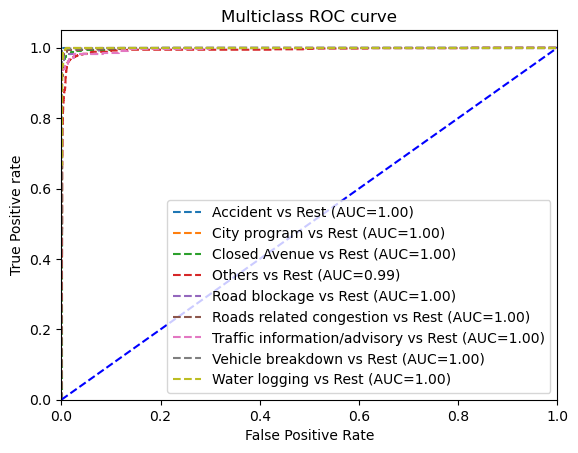

In [33]:
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve,auc

# roc curve for classes
fpr = {}
tpr = {}
thresh ={}
roc_auc = dict()

classes = lb.classes_

for i in range(len(classes)):
    # fpr[i], tpr[i], thresh[i] = roc_curve(y_test_binarized[:,i], pred_prob[:,i])
    fpr[i], tpr[i], thresh[i] = roc_curve(Y_test[:,i], pred_test[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

    # plotting
    plt.plot(fpr[i], tpr[i], linestyle='--',
             label='%s vs Rest (AUC=%0.2f)'%(classes[i],roc_auc[i]))

plt.plot([0,1],[0,1],'b--')
plt.xlim([0,1])
plt.ylim([0,1.05])
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='lower right')
plt.show()

## Calculating Evaluation Metric

In [53]:
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import roc_auc_score
accuracy = accuracy_score(y_test, y_pred)
precision, recall, fscore,_  = score(y_test, y_pred, average='macro')
roc_auc = roc_auc_score(y_test, pred_test,multi_class='ovr')
print('Accuracy, precision, recall, fscore, Roc-AUC')
print('{:.3f},{:.3f},{:.3f},{:.3f},{:.3f}'.format(accuracy,precision,recall,fscore,roc_auc))

Accuracy, precision, recall, fscore, Roc-AUC
0.970,0.961,0.963,0.962,0.998


## Test on Customized Tweet

In [55]:
lb.classes_

array(['Accident', 'City program', 'Closed Avenue', 'Others',
       'Road blockage', 'Roads related congestion',
       'Traffic information/advisory', 'Vehicle breakdown',
       'Water logging'], dtype='<U28')

In [57]:
new_complaint = ['Severe accident on 1 no street']
seq = tokenizer.texts_to_sequences(new_complaint)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)
print(pred)
print('Label: {}'.format(lb.classes_[np.argmax(pred)]))

1/1 [==============================] - 1s 826ms/step
[[9.8400176e-01 1.8980337e-04 2.1154427e-05 1.4775081e-03 3.5597300e-03
  7.2513954e-03 1.2929438e-04 6.3131156e-04 2.7379517e-03]]
Label: Accident
